# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

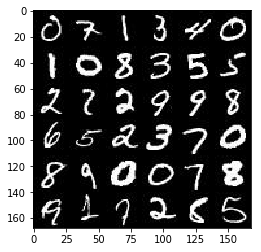

In [2]:
show_n_images = 40

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

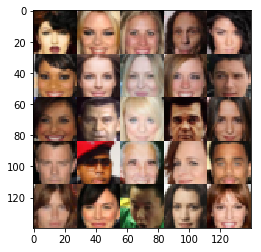

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), name='z_inputs')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        conv1 = tf.layers.conv2d(images, filters=64, kernel_size=5,  strides = 2, activation=None, padding='SAME')
        conv1 = tf.maximum(conv1 * alpha, conv1)
        
        conv2 = tf.layers.conv2d(conv1, filters=128, kernel_size=5, strides = 2, activation=None, padding='SAME')
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(conv2 * alpha, conv2)
        
        conv3 = tf.layers.conv2d(conv2, filters=256, kernel_size=5, strides = 2, activation=None, padding='SAME')
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(conv3 * alpha, conv3)

        
        fc = tf.reshape(conv3, (-1, (4*4*256)))
        logits = tf.layers.dense(fc, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        
        fclayer = tf.layers.dense(z, 3*3*1024)
        
        fclayer = tf.reshape(fclayer, (-1, 3, 3, 1024))
        fclayer = tf.layers.batch_normalization(fclayer, training=is_train)
        fclayer = tf.maximum(alpha * fclayer, fclayer)
        
        conv2 = tf.layers.conv2d_transpose(fclayer, filters = 512, kernel_size = 3, strides = 2, activation=None, padding='VALID')
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(alpha * conv2, conv2)
        #print(conv2)
        
        conv3 = tf.layers.conv2d_transpose(conv2, filters = 256, kernel_size = 5, strides = 2, activation=None, padding='SAME')
        conv3 = tf.layers.batch_normalization(conv3, training=is_train)
        conv3 = tf.maximum(alpha * conv3, conv3)
        
      
        logits = tf.layers.conv2d_transpose(conv3, filters = out_channel_dim, kernel_size = 5, strides = 2, activation=None, padding='SAME')
        #conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        #conv2 = tf.maximum(alpha * conv1, conv1)
        out = tf.tanh(logits)
        
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    gen_images = generator(input_z, out_channel_dim, is_train = True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(gen_images, reuse=True)
    
    smooth_factor = 0.1
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real, labels = tf.ones_like(d_model_real)  * (1 - smooth_factor))) 
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.zeros_like(d_model_fake))) 
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.ones_like(d_model_fake))) 
    
    return d_loss_real + d_loss_fake, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
    
    g_vars = [var for var in train_vars if var.name.startswith('generator')]
    d_vars = [var for var in train_vars if var.name.startswith('discriminator')]

    # what does this with do?
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # is below bad?

    
    #if(data_image_mode ==  "RGB"):
        #depth = 3
    #else: #L
     #   depth = 1
    
    # model_inputs(image_width, image_height, image_channels, z_dim):
    #real_inputs, z_inputs, learning_rate
    #60000, 28, 28, 1
    # what is z_dim?
    #print(data_shape)
    real_inputs, z_inputs, lrn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    #return d_loss_real + d_loss_fake, g_loss
    d_loss, g_loss = model_loss(real_inputs, z_inputs, data_shape[3])

    #return d_train_opt, g_train_opt
    d_opt, g_opt = model_opt(d_loss, g_loss, lrn_rate, beta1)
    sample_z = tf.constant(np.random.uniform(-1, 1, size=(25, z_dim)), dtype=tf.float32)
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                # Sample random noise for G
                #-1 to 1 or 0.5?
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                #print(batch_z)

                # Run optimizers
                # discriminator(images, reuse=False):
                # generator(z, out_channel_dim, is_train=True):
                
                _ = sess.run(d_opt, feed_dict={real_inputs: batch_images, z_inputs: batch_z, lrn_rate: learning_rate })
                _ = sess.run(g_opt, feed_dict={z_inputs: batch_z, real_inputs: batch_images, lrn_rate: learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    #d_loss, g_loss = model_loss()
                    #(input_real, input_z, out_channel_dim):
                    train_loss_d = d_loss.eval({real_inputs: batch_images, z_inputs: batch_z})
                    train_loss_g = g_loss.eval({z_inputs: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    #losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    #(sess, n_images, input_z, out_channel_dim, image_mode):
                    show_generator_output(sess, 25, sample_z, data_shape[3], data_image_mode)
        #print one last time at end of training
        show_generator_output(sess, 25, sample_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.9060... Generator Loss: 1.0356
Epoch 1/2... Discriminator Loss: 1.1851... Generator Loss: 0.6455
Epoch 1/2... Discriminator Loss: 0.7888... Generator Loss: 2.6874
Epoch 1/2... Discriminator Loss: 1.5983... Generator Loss: 0.5201
Epoch 1/2... Discriminator Loss: 1.2509... Generator Loss: 1.0027
Epoch 1/2... Discriminator Loss: 1.0059... Generator Loss: 2.5933
Epoch 1/2... Discriminator Loss: 0.6394... Generator Loss: 1.7457
Epoch 1/2... Discriminator Loss: 1.1756... Generator Loss: 0.8746
Epoch 1/2... Discriminator Loss: 1.0210... Generator Loss: 1.3956
Epoch 1/2... Discriminator Loss: 1.2925... Generator Loss: 0.6709


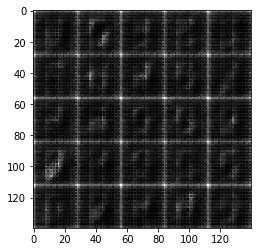

Epoch 1/2... Discriminator Loss: 1.2175... Generator Loss: 1.0318
Epoch 1/2... Discriminator Loss: 1.4274... Generator Loss: 0.5515
Epoch 1/2... Discriminator Loss: 1.0917... Generator Loss: 0.9468
Epoch 1/2... Discriminator Loss: 1.0845... Generator Loss: 1.5846
Epoch 1/2... Discriminator Loss: 1.2685... Generator Loss: 0.8444
Epoch 1/2... Discriminator Loss: 1.0613... Generator Loss: 1.3011
Epoch 1/2... Discriminator Loss: 1.1819... Generator Loss: 1.4270
Epoch 1/2... Discriminator Loss: 1.1531... Generator Loss: 0.8047
Epoch 1/2... Discriminator Loss: 1.1940... Generator Loss: 0.7445
Epoch 1/2... Discriminator Loss: 1.2069... Generator Loss: 1.0669


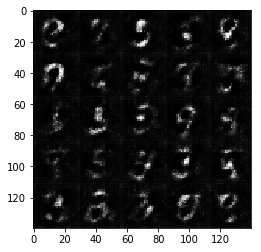

Epoch 1/2... Discriminator Loss: 1.1246... Generator Loss: 1.5023
Epoch 1/2... Discriminator Loss: 1.2082... Generator Loss: 0.7472
Epoch 1/2... Discriminator Loss: 1.1829... Generator Loss: 1.7304
Epoch 1/2... Discriminator Loss: 1.1235... Generator Loss: 0.9798
Epoch 1/2... Discriminator Loss: 1.0634... Generator Loss: 1.2539
Epoch 1/2... Discriminator Loss: 1.1170... Generator Loss: 1.0711
Epoch 1/2... Discriminator Loss: 1.1201... Generator Loss: 0.8086
Epoch 1/2... Discriminator Loss: 1.1252... Generator Loss: 0.7692
Epoch 1/2... Discriminator Loss: 1.0401... Generator Loss: 1.0853
Epoch 1/2... Discriminator Loss: 1.1509... Generator Loss: 0.6889


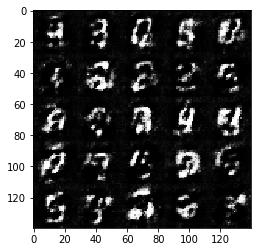

Epoch 1/2... Discriminator Loss: 1.0075... Generator Loss: 1.2066
Epoch 1/2... Discriminator Loss: 1.0874... Generator Loss: 1.7267
Epoch 1/2... Discriminator Loss: 1.1079... Generator Loss: 0.7645
Epoch 1/2... Discriminator Loss: 0.9559... Generator Loss: 1.0575
Epoch 1/2... Discriminator Loss: 0.8757... Generator Loss: 1.1197
Epoch 1/2... Discriminator Loss: 0.9432... Generator Loss: 1.1720
Epoch 1/2... Discriminator Loss: 1.7261... Generator Loss: 3.0349
Epoch 1/2... Discriminator Loss: 0.8867... Generator Loss: 1.2161
Epoch 1/2... Discriminator Loss: 0.9535... Generator Loss: 1.5059
Epoch 1/2... Discriminator Loss: 1.1504... Generator Loss: 0.6657


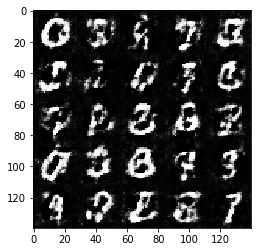

Epoch 1/2... Discriminator Loss: 0.9333... Generator Loss: 0.9338
Epoch 1/2... Discriminator Loss: 0.9689... Generator Loss: 1.6384
Epoch 1/2... Discriminator Loss: 1.1740... Generator Loss: 0.6267
Epoch 1/2... Discriminator Loss: 1.0591... Generator Loss: 0.7955
Epoch 1/2... Discriminator Loss: 1.1754... Generator Loss: 0.6547
Epoch 1/2... Discriminator Loss: 0.9372... Generator Loss: 1.1151
Epoch 1/2... Discriminator Loss: 0.8200... Generator Loss: 1.3045
Epoch 1/2... Discriminator Loss: 0.9217... Generator Loss: 1.7004
Epoch 1/2... Discriminator Loss: 1.1360... Generator Loss: 0.6502
Epoch 1/2... Discriminator Loss: 1.1055... Generator Loss: 0.7056


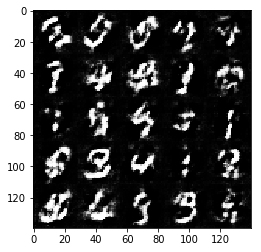

Epoch 1/2... Discriminator Loss: 0.8432... Generator Loss: 1.4074
Epoch 1/2... Discriminator Loss: 0.9786... Generator Loss: 2.2000
Epoch 1/2... Discriminator Loss: 1.0615... Generator Loss: 0.7789
Epoch 1/2... Discriminator Loss: 1.0016... Generator Loss: 2.1625
Epoch 1/2... Discriminator Loss: 1.0291... Generator Loss: 1.6291
Epoch 1/2... Discriminator Loss: 0.9653... Generator Loss: 0.9969
Epoch 1/2... Discriminator Loss: 0.9108... Generator Loss: 1.3702
Epoch 1/2... Discriminator Loss: 0.9369... Generator Loss: 1.0645
Epoch 1/2... Discriminator Loss: 1.1411... Generator Loss: 0.7088
Epoch 1/2... Discriminator Loss: 1.0054... Generator Loss: 0.8947


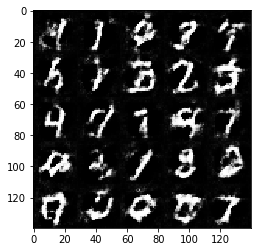

Epoch 1/2... Discriminator Loss: 0.9397... Generator Loss: 1.7065
Epoch 1/2... Discriminator Loss: 0.9032... Generator Loss: 1.3145
Epoch 1/2... Discriminator Loss: 0.9790... Generator Loss: 1.8447
Epoch 1/2... Discriminator Loss: 0.9792... Generator Loss: 0.9519
Epoch 1/2... Discriminator Loss: 1.0255... Generator Loss: 1.3902
Epoch 1/2... Discriminator Loss: 1.2217... Generator Loss: 1.9542
Epoch 1/2... Discriminator Loss: 0.9122... Generator Loss: 1.2348
Epoch 1/2... Discriminator Loss: 1.3677... Generator Loss: 0.4916
Epoch 1/2... Discriminator Loss: 0.9469... Generator Loss: 1.1452
Epoch 1/2... Discriminator Loss: 0.9271... Generator Loss: 1.0615


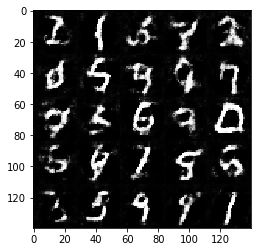

Epoch 1/2... Discriminator Loss: 0.9809... Generator Loss: 1.0206
Epoch 1/2... Discriminator Loss: 1.0576... Generator Loss: 1.3177
Epoch 1/2... Discriminator Loss: 1.0691... Generator Loss: 0.8041
Epoch 1/2... Discriminator Loss: 1.0034... Generator Loss: 1.2605
Epoch 1/2... Discriminator Loss: 1.0106... Generator Loss: 0.9338
Epoch 1/2... Discriminator Loss: 1.0727... Generator Loss: 1.2301
Epoch 1/2... Discriminator Loss: 0.9491... Generator Loss: 1.2562
Epoch 1/2... Discriminator Loss: 1.1442... Generator Loss: 1.7988
Epoch 1/2... Discriminator Loss: 0.9396... Generator Loss: 1.5584
Epoch 1/2... Discriminator Loss: 1.0027... Generator Loss: 1.4108


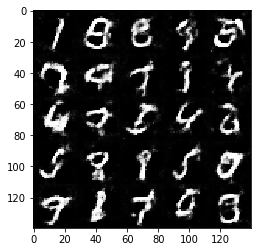

Epoch 1/2... Discriminator Loss: 0.9974... Generator Loss: 1.3794
Epoch 1/2... Discriminator Loss: 1.0474... Generator Loss: 1.4322
Epoch 1/2... Discriminator Loss: 1.0230... Generator Loss: 1.6985
Epoch 1/2... Discriminator Loss: 1.1162... Generator Loss: 0.7398
Epoch 1/2... Discriminator Loss: 1.0604... Generator Loss: 0.8876
Epoch 1/2... Discriminator Loss: 1.2251... Generator Loss: 0.5799
Epoch 1/2... Discriminator Loss: 1.0301... Generator Loss: 1.2319
Epoch 1/2... Discriminator Loss: 1.0292... Generator Loss: 0.8286
Epoch 1/2... Discriminator Loss: 1.0880... Generator Loss: 0.7939
Epoch 1/2... Discriminator Loss: 0.9877... Generator Loss: 1.0469


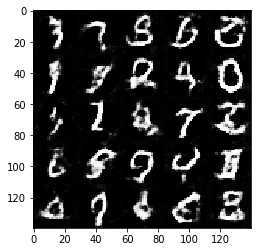

Epoch 1/2... Discriminator Loss: 1.1165... Generator Loss: 0.7678
Epoch 1/2... Discriminator Loss: 1.0142... Generator Loss: 1.2131
Epoch 1/2... Discriminator Loss: 1.0617... Generator Loss: 1.6020
Epoch 2/2... Discriminator Loss: 0.9778... Generator Loss: 1.4181
Epoch 2/2... Discriminator Loss: 1.0380... Generator Loss: 0.8625
Epoch 2/2... Discriminator Loss: 0.9885... Generator Loss: 1.4641
Epoch 2/2... Discriminator Loss: 1.0134... Generator Loss: 1.1165
Epoch 2/2... Discriminator Loss: 1.0570... Generator Loss: 1.5639
Epoch 2/2... Discriminator Loss: 0.9955... Generator Loss: 1.5672
Epoch 2/2... Discriminator Loss: 1.4459... Generator Loss: 0.4479


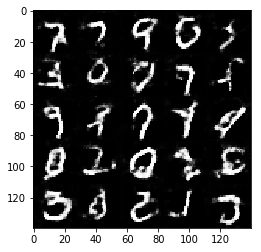

Epoch 2/2... Discriminator Loss: 0.9864... Generator Loss: 0.9768
Epoch 2/2... Discriminator Loss: 1.1314... Generator Loss: 0.7292
Epoch 2/2... Discriminator Loss: 1.0271... Generator Loss: 1.4246
Epoch 2/2... Discriminator Loss: 1.0744... Generator Loss: 0.7726
Epoch 2/2... Discriminator Loss: 1.4787... Generator Loss: 0.4604
Epoch 2/2... Discriminator Loss: 1.0434... Generator Loss: 1.6106
Epoch 2/2... Discriminator Loss: 1.0213... Generator Loss: 0.9518
Epoch 2/2... Discriminator Loss: 1.0212... Generator Loss: 1.4739
Epoch 2/2... Discriminator Loss: 1.0050... Generator Loss: 1.0556
Epoch 2/2... Discriminator Loss: 1.0183... Generator Loss: 0.9644


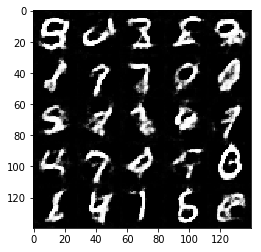

Epoch 2/2... Discriminator Loss: 1.1525... Generator Loss: 1.7930
Epoch 2/2... Discriminator Loss: 1.2130... Generator Loss: 0.6551
Epoch 2/2... Discriminator Loss: 1.0486... Generator Loss: 0.9191
Epoch 2/2... Discriminator Loss: 1.2648... Generator Loss: 0.5781
Epoch 2/2... Discriminator Loss: 0.9543... Generator Loss: 1.1133
Epoch 2/2... Discriminator Loss: 0.9915... Generator Loss: 1.1230
Epoch 2/2... Discriminator Loss: 1.2496... Generator Loss: 1.9670
Epoch 2/2... Discriminator Loss: 1.0150... Generator Loss: 1.2109
Epoch 2/2... Discriminator Loss: 1.4253... Generator Loss: 0.4556
Epoch 2/2... Discriminator Loss: 1.0018... Generator Loss: 1.0213


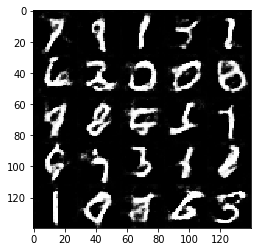

Epoch 2/2... Discriminator Loss: 1.0044... Generator Loss: 0.9566
Epoch 2/2... Discriminator Loss: 1.1761... Generator Loss: 0.6857
Epoch 2/2... Discriminator Loss: 1.0888... Generator Loss: 0.7876
Epoch 2/2... Discriminator Loss: 1.1749... Generator Loss: 1.3697
Epoch 2/2... Discriminator Loss: 0.9924... Generator Loss: 0.9495
Epoch 2/2... Discriminator Loss: 1.0370... Generator Loss: 1.2295
Epoch 2/2... Discriminator Loss: 1.3664... Generator Loss: 2.0852
Epoch 2/2... Discriminator Loss: 1.0067... Generator Loss: 0.9374
Epoch 2/2... Discriminator Loss: 0.8904... Generator Loss: 1.4004
Epoch 2/2... Discriminator Loss: 1.0686... Generator Loss: 1.5924


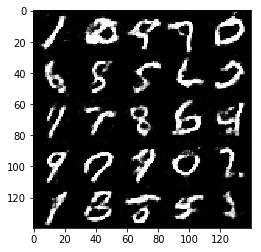

Epoch 2/2... Discriminator Loss: 0.9806... Generator Loss: 1.1203
Epoch 2/2... Discriminator Loss: 0.9992... Generator Loss: 1.1463
Epoch 2/2... Discriminator Loss: 0.9894... Generator Loss: 1.0395
Epoch 2/2... Discriminator Loss: 1.0212... Generator Loss: 1.0743
Epoch 2/2... Discriminator Loss: 1.0467... Generator Loss: 1.4541
Epoch 2/2... Discriminator Loss: 0.9572... Generator Loss: 1.4340
Epoch 2/2... Discriminator Loss: 1.0150... Generator Loss: 1.2132
Epoch 2/2... Discriminator Loss: 0.9661... Generator Loss: 0.9916
Epoch 2/2... Discriminator Loss: 1.0619... Generator Loss: 0.9448
Epoch 2/2... Discriminator Loss: 0.9619... Generator Loss: 1.1507


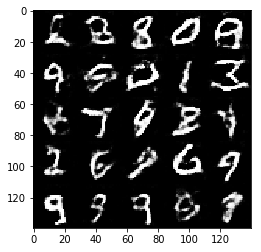

Epoch 2/2... Discriminator Loss: 0.9555... Generator Loss: 1.3565
Epoch 2/2... Discriminator Loss: 1.1255... Generator Loss: 1.6439
Epoch 2/2... Discriminator Loss: 1.0189... Generator Loss: 1.4446
Epoch 2/2... Discriminator Loss: 0.9673... Generator Loss: 1.3761
Epoch 2/2... Discriminator Loss: 1.1000... Generator Loss: 0.8974
Epoch 2/2... Discriminator Loss: 0.9747... Generator Loss: 1.0850
Epoch 2/2... Discriminator Loss: 1.0539... Generator Loss: 0.8624
Epoch 2/2... Discriminator Loss: 1.0813... Generator Loss: 0.7659
Epoch 2/2... Discriminator Loss: 0.9270... Generator Loss: 1.4491
Epoch 2/2... Discriminator Loss: 1.0493... Generator Loss: 1.5882


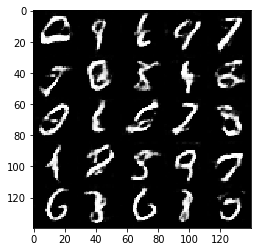

Epoch 2/2... Discriminator Loss: 1.4125... Generator Loss: 0.5031
Epoch 2/2... Discriminator Loss: 1.1983... Generator Loss: 0.6574
Epoch 2/2... Discriminator Loss: 0.9224... Generator Loss: 1.0875
Epoch 2/2... Discriminator Loss: 0.9530... Generator Loss: 0.9522
Epoch 2/2... Discriminator Loss: 1.1285... Generator Loss: 0.7631
Epoch 2/2... Discriminator Loss: 0.9227... Generator Loss: 1.1192
Epoch 2/2... Discriminator Loss: 0.9126... Generator Loss: 1.1286
Epoch 2/2... Discriminator Loss: 1.0992... Generator Loss: 0.7664
Epoch 2/2... Discriminator Loss: 1.0505... Generator Loss: 1.6008
Epoch 2/2... Discriminator Loss: 0.9867... Generator Loss: 0.8669


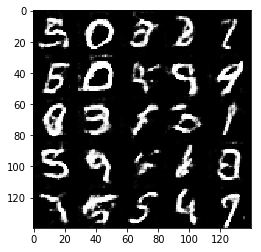

Epoch 2/2... Discriminator Loss: 1.0878... Generator Loss: 0.7803
Epoch 2/2... Discriminator Loss: 0.9908... Generator Loss: 1.8224
Epoch 2/2... Discriminator Loss: 0.9426... Generator Loss: 1.7795
Epoch 2/2... Discriminator Loss: 0.9030... Generator Loss: 1.2113
Epoch 2/2... Discriminator Loss: 0.9641... Generator Loss: 1.2993
Epoch 2/2... Discriminator Loss: 0.9118... Generator Loss: 1.2435
Epoch 2/2... Discriminator Loss: 0.8872... Generator Loss: 1.1314
Epoch 2/2... Discriminator Loss: 0.8619... Generator Loss: 1.4218
Epoch 2/2... Discriminator Loss: 0.9450... Generator Loss: 0.9875
Epoch 2/2... Discriminator Loss: 0.9287... Generator Loss: 1.2538


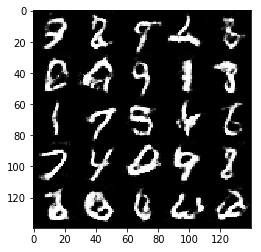

Epoch 2/2... Discriminator Loss: 1.8586... Generator Loss: 0.2953
Epoch 2/2... Discriminator Loss: 1.0244... Generator Loss: 0.9151
Epoch 2/2... Discriminator Loss: 0.9794... Generator Loss: 0.9060
Epoch 2/2... Discriminator Loss: 0.9556... Generator Loss: 1.4904
Epoch 2/2... Discriminator Loss: 0.8999... Generator Loss: 0.9859
Epoch 2/2... Discriminator Loss: 1.1585... Generator Loss: 0.6960
Epoch 2/2... Discriminator Loss: 0.9231... Generator Loss: 1.1302
Epoch 2/2... Discriminator Loss: 0.8288... Generator Loss: 1.3993
Epoch 2/2... Discriminator Loss: 0.9722... Generator Loss: 1.0123
Epoch 2/2... Discriminator Loss: 1.1869... Generator Loss: 1.5791


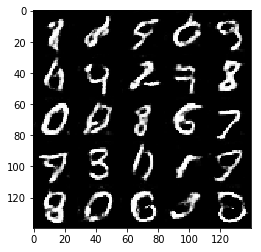

Epoch 2/2... Discriminator Loss: 0.8511... Generator Loss: 1.3165
Epoch 2/2... Discriminator Loss: 1.1579... Generator Loss: 0.6542
Epoch 2/2... Discriminator Loss: 1.0206... Generator Loss: 0.8786
Epoch 2/2... Discriminator Loss: 0.9019... Generator Loss: 1.2414
Epoch 2/2... Discriminator Loss: 0.9571... Generator Loss: 1.2581
Epoch 2/2... Discriminator Loss: 0.9148... Generator Loss: 1.1489
Epoch 2/2... Discriminator Loss: 1.0240... Generator Loss: 0.8097


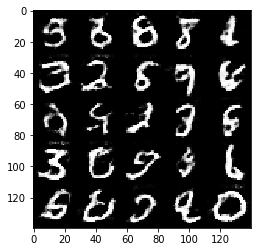

In [12]:
batch_size = 64
z_dim = 100
learning_rate = .0001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.7739... Generator Loss: 0.4173
Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.0153... Generator Loss: 1.0300
Epoch 1/1... Discriminator Loss: 0.7711... Generator Loss: 1.5560
Epoch 1/1... Discriminator Loss: 0.6544... Generator Loss: 1.7707
Epoch 1/1... Discriminator Loss: 0.6004... Generator Loss: 2.1181
Epoch 1/1... Discriminator Loss: 0.7126... Generator Loss: 1.8356
Epoch 1/1... Discriminator Loss: 0.7172... Generator Loss: 3.2908
Epoch 1/1... Discriminator Loss: 0.9554... Generator Loss: 1.2836
Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 1.2417


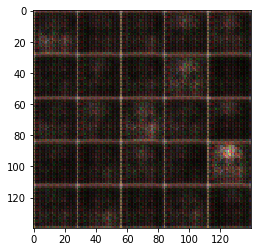

Epoch 1/1... Discriminator Loss: 0.9547... Generator Loss: 1.5309
Epoch 1/1... Discriminator Loss: 1.0765... Generator Loss: 1.4566
Epoch 1/1... Discriminator Loss: 1.0966... Generator Loss: 1.3552
Epoch 1/1... Discriminator Loss: 1.2963... Generator Loss: 0.6236
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.5784
Epoch 1/1... Discriminator Loss: 1.0815... Generator Loss: 1.0690
Epoch 1/1... Discriminator Loss: 1.0880... Generator Loss: 1.1177
Epoch 1/1... Discriminator Loss: 0.9579... Generator Loss: 1.4482
Epoch 1/1... Discriminator Loss: 1.2544... Generator Loss: 1.3363
Epoch 1/1... Discriminator Loss: 1.4817... Generator Loss: 0.5488


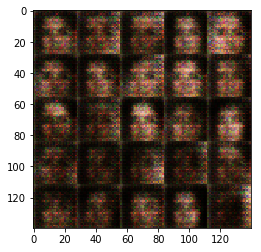

Epoch 1/1... Discriminator Loss: 1.1870... Generator Loss: 0.9484
Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 0.9394
Epoch 1/1... Discriminator Loss: 1.2366... Generator Loss: 0.8327
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.7903
Epoch 1/1... Discriminator Loss: 1.2967... Generator Loss: 1.0370
Epoch 1/1... Discriminator Loss: 1.1648... Generator Loss: 1.0646
Epoch 1/1... Discriminator Loss: 1.0751... Generator Loss: 0.9998
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.6304
Epoch 1/1... Discriminator Loss: 1.5091... Generator Loss: 1.0697
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.6771


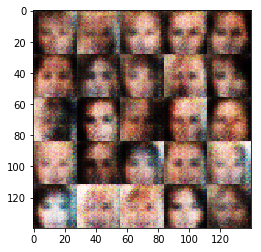

Epoch 1/1... Discriminator Loss: 1.3040... Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.9128
Epoch 1/1... Discriminator Loss: 1.5794... Generator Loss: 0.4357
Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 1.2718
Epoch 1/1... Discriminator Loss: 1.1326... Generator Loss: 1.1053
Epoch 1/1... Discriminator Loss: 1.0581... Generator Loss: 0.9470
Epoch 1/1... Discriminator Loss: 1.4457... Generator Loss: 0.6334
Epoch 1/1... Discriminator Loss: 1.1897... Generator Loss: 0.9620
Epoch 1/1... Discriminator Loss: 1.0040... Generator Loss: 1.6933
Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 0.6222


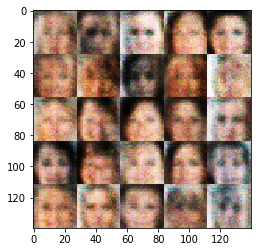

Epoch 1/1... Discriminator Loss: 1.0178... Generator Loss: 0.9856
Epoch 1/1... Discriminator Loss: 1.0516... Generator Loss: 0.9825
Epoch 1/1... Discriminator Loss: 1.1626... Generator Loss: 1.0510
Epoch 1/1... Discriminator Loss: 0.9762... Generator Loss: 1.4517
Epoch 1/1... Discriminator Loss: 1.1342... Generator Loss: 1.2166
Epoch 1/1... Discriminator Loss: 1.0629... Generator Loss: 1.5080
Epoch 1/1... Discriminator Loss: 0.9937... Generator Loss: 1.3104
Epoch 1/1... Discriminator Loss: 1.7157... Generator Loss: 0.3554
Epoch 1/1... Discriminator Loss: 1.2528... Generator Loss: 2.6189
Epoch 1/1... Discriminator Loss: 1.2432... Generator Loss: 0.7468


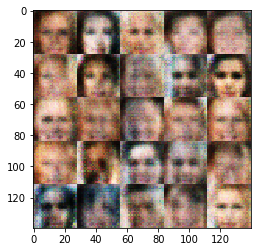

Epoch 1/1... Discriminator Loss: 1.0268... Generator Loss: 0.9229
Epoch 1/1... Discriminator Loss: 0.9315... Generator Loss: 1.3951
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.7518
Epoch 1/1... Discriminator Loss: 1.2536... Generator Loss: 0.6669
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.5212
Epoch 1/1... Discriminator Loss: 0.7689... Generator Loss: 1.6623
Epoch 1/1... Discriminator Loss: 0.9202... Generator Loss: 1.3324
Epoch 1/1... Discriminator Loss: 1.1159... Generator Loss: 1.4818
Epoch 1/1... Discriminator Loss: 1.5357... Generator Loss: 0.4899
Epoch 1/1... Discriminator Loss: 1.2958... Generator Loss: 0.6858


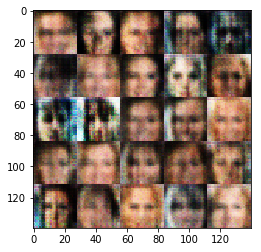

Epoch 1/1... Discriminator Loss: 1.1521... Generator Loss: 2.3961
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.6005
Epoch 1/1... Discriminator Loss: 1.4828... Generator Loss: 1.3361
Epoch 1/1... Discriminator Loss: 1.1409... Generator Loss: 1.5383
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.9274
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.6448
Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 1.6473
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.8700
Epoch 1/1... Discriminator Loss: 1.0720... Generator Loss: 1.7447
Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.7502


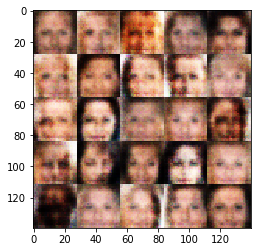

Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 0.8843
Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 0.7059
Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.2400... Generator Loss: 0.8901
Epoch 1/1... Discriminator Loss: 1.2404... Generator Loss: 0.9984
Epoch 1/1... Discriminator Loss: 1.0386... Generator Loss: 1.3137
Epoch 1/1... Discriminator Loss: 1.1009... Generator Loss: 1.1605
Epoch 1/1... Discriminator Loss: 1.0264... Generator Loss: 1.2141
Epoch 1/1... Discriminator Loss: 1.5179... Generator Loss: 0.5058


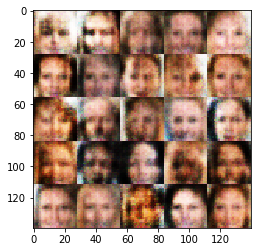

Epoch 1/1... Discriminator Loss: 1.2208... Generator Loss: 0.7953
Epoch 1/1... Discriminator Loss: 1.1676... Generator Loss: 1.1291
Epoch 1/1... Discriminator Loss: 1.1313... Generator Loss: 2.1557
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.7437
Epoch 1/1... Discriminator Loss: 1.0305... Generator Loss: 1.7172
Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 0.7038
Epoch 1/1... Discriminator Loss: 1.1360... Generator Loss: 1.0926
Epoch 1/1... Discriminator Loss: 1.2486... Generator Loss: 0.9141
Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 1.6336
Epoch 1/1... Discriminator Loss: 1.0615... Generator Loss: 1.0382


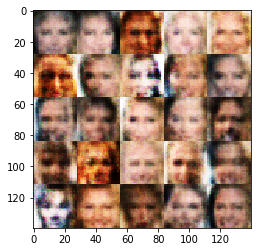

Epoch 1/1... Discriminator Loss: 2.0640... Generator Loss: 0.2172
Epoch 1/1... Discriminator Loss: 1.2947... Generator Loss: 0.6414
Epoch 1/1... Discriminator Loss: 1.0531... Generator Loss: 0.9987
Epoch 1/1... Discriminator Loss: 0.9883... Generator Loss: 1.0131
Epoch 1/1... Discriminator Loss: 1.2050... Generator Loss: 0.6700
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 2.1426
Epoch 1/1... Discriminator Loss: 0.9867... Generator Loss: 2.3222
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.5481
Epoch 1/1... Discriminator Loss: 1.1121... Generator Loss: 0.9249
Epoch 1/1... Discriminator Loss: 0.8158... Generator Loss: 2.0353


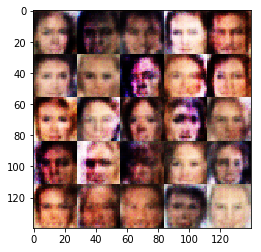

Epoch 1/1... Discriminator Loss: 1.6267... Generator Loss: 3.3662
Epoch 1/1... Discriminator Loss: 1.4871... Generator Loss: 2.8329
Epoch 1/1... Discriminator Loss: 1.6672... Generator Loss: 0.3915
Epoch 1/1... Discriminator Loss: 0.8898... Generator Loss: 2.3710
Epoch 1/1... Discriminator Loss: 0.9405... Generator Loss: 1.0742
Epoch 1/1... Discriminator Loss: 1.1262... Generator Loss: 0.7933
Epoch 1/1... Discriminator Loss: 1.6375... Generator Loss: 0.4040
Epoch 1/1... Discriminator Loss: 1.2598... Generator Loss: 0.7802
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.5135
Epoch 1/1... Discriminator Loss: 0.7971... Generator Loss: 1.2765


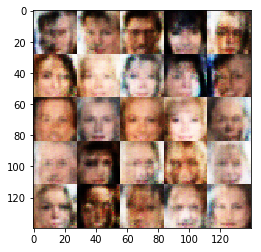

Epoch 1/1... Discriminator Loss: 0.8932... Generator Loss: 1.3489
Epoch 1/1... Discriminator Loss: 1.5321... Generator Loss: 0.4084
Epoch 1/1... Discriminator Loss: 0.8898... Generator Loss: 1.3015
Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.5810
Epoch 1/1... Discriminator Loss: 0.7519... Generator Loss: 1.9637
Epoch 1/1... Discriminator Loss: 1.1915... Generator Loss: 1.2378
Epoch 1/1... Discriminator Loss: 1.1063... Generator Loss: 0.9051
Epoch 1/1... Discriminator Loss: 1.4727... Generator Loss: 0.5779
Epoch 1/1... Discriminator Loss: 0.9231... Generator Loss: 1.1652
Epoch 1/1... Discriminator Loss: 1.1396... Generator Loss: 0.7178


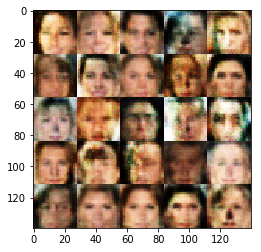

Epoch 1/1... Discriminator Loss: 1.2275... Generator Loss: 1.0886
Epoch 1/1... Discriminator Loss: 1.0850... Generator Loss: 1.6640
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.5414
Epoch 1/1... Discriminator Loss: 1.2742... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 0.9169... Generator Loss: 1.5597
Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.4984
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 1.7481
Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 1.1965
Epoch 1/1... Discriminator Loss: 1.1007... Generator Loss: 0.9051
Epoch 1/1... Discriminator Loss: 1.0156... Generator Loss: 2.6283


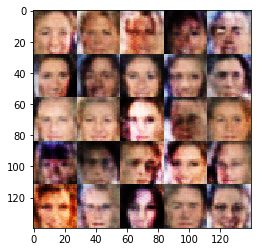

Epoch 1/1... Discriminator Loss: 1.2698... Generator Loss: 0.5934
Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.5945
Epoch 1/1... Discriminator Loss: 1.2388... Generator Loss: 0.8230
Epoch 1/1... Discriminator Loss: 1.2244... Generator Loss: 1.3120
Epoch 1/1... Discriminator Loss: 1.0896... Generator Loss: 0.8560
Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 0.9803... Generator Loss: 2.1670
Epoch 1/1... Discriminator Loss: 1.1129... Generator Loss: 0.8685
Epoch 1/1... Discriminator Loss: 1.4703... Generator Loss: 0.4819
Epoch 1/1... Discriminator Loss: 1.2311... Generator Loss: 0.6380


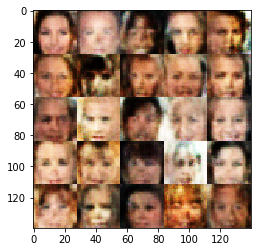

Epoch 1/1... Discriminator Loss: 1.2043... Generator Loss: 0.6681
Epoch 1/1... Discriminator Loss: 1.1112... Generator Loss: 1.0208
Epoch 1/1... Discriminator Loss: 1.1931... Generator Loss: 0.6933
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.6302
Epoch 1/1... Discriminator Loss: 0.8796... Generator Loss: 1.5257
Epoch 1/1... Discriminator Loss: 0.9246... Generator Loss: 1.2565
Epoch 1/1... Discriminator Loss: 0.8576... Generator Loss: 1.3802
Epoch 1/1... Discriminator Loss: 1.0161... Generator Loss: 1.5989
Epoch 1/1... Discriminator Loss: 0.9670... Generator Loss: 2.0732
Epoch 1/1... Discriminator Loss: 0.9894... Generator Loss: 1.4816


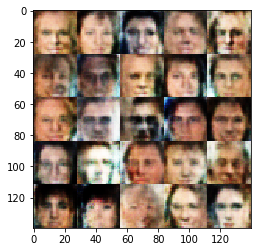

Epoch 1/1... Discriminator Loss: 1.1409... Generator Loss: 1.7985
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.4904
Epoch 1/1... Discriminator Loss: 1.6001... Generator Loss: 0.3938
Epoch 1/1... Discriminator Loss: 1.5258... Generator Loss: 0.4950
Epoch 1/1... Discriminator Loss: 1.2380... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 1.0287... Generator Loss: 1.3527
Epoch 1/1... Discriminator Loss: 1.2486... Generator Loss: 0.9909
Epoch 1/1... Discriminator Loss: 1.1845... Generator Loss: 0.8184
Epoch 1/1... Discriminator Loss: 1.1464... Generator Loss: 0.8283


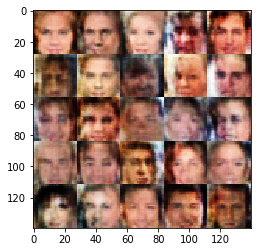

Epoch 1/1... Discriminator Loss: 1.1635... Generator Loss: 0.9343
Epoch 1/1... Discriminator Loss: 1.1546... Generator Loss: 0.8977
Epoch 1/1... Discriminator Loss: 1.5587... Generator Loss: 0.4254
Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 1.2690... Generator Loss: 0.6228
Epoch 1/1... Discriminator Loss: 1.1010... Generator Loss: 1.0217
Epoch 1/1... Discriminator Loss: 1.1059... Generator Loss: 0.9030
Epoch 1/1... Discriminator Loss: 1.1791... Generator Loss: 1.4307
Epoch 1/1... Discriminator Loss: 0.9566... Generator Loss: 1.3155
Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.5874


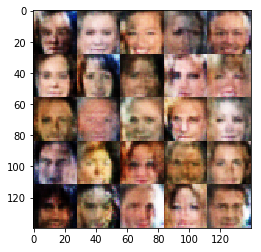

Epoch 1/1... Discriminator Loss: 1.1771... Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 1.1681... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 0.5730
Epoch 1/1... Discriminator Loss: 1.0851... Generator Loss: 1.6133
Epoch 1/1... Discriminator Loss: 1.0634... Generator Loss: 1.0599
Epoch 1/1... Discriminator Loss: 1.1014... Generator Loss: 0.8335
Epoch 1/1... Discriminator Loss: 1.0328... Generator Loss: 1.5972
Epoch 1/1... Discriminator Loss: 1.2392... Generator Loss: 0.8108
Epoch 1/1... Discriminator Loss: 1.1743... Generator Loss: 0.8334
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.5739


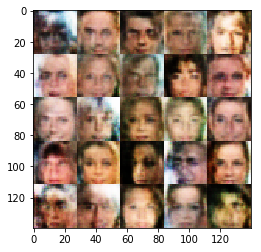

Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 1.0162... Generator Loss: 1.0476
Epoch 1/1... Discriminator Loss: 1.1261... Generator Loss: 1.0207
Epoch 1/1... Discriminator Loss: 1.0078... Generator Loss: 2.0401
Epoch 1/1... Discriminator Loss: 1.1607... Generator Loss: 0.8265
Epoch 1/1... Discriminator Loss: 0.9253... Generator Loss: 1.8235
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.8612
Epoch 1/1... Discriminator Loss: 0.9884... Generator Loss: 1.2992
Epoch 1/1... Discriminator Loss: 1.1301... Generator Loss: 0.9410
Epoch 1/1... Discriminator Loss: 0.8557... Generator Loss: 2.3239


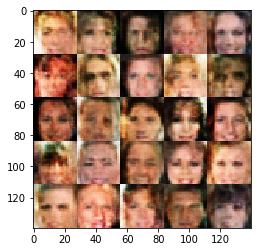

Epoch 1/1... Discriminator Loss: 1.0717... Generator Loss: 1.6558
Epoch 1/1... Discriminator Loss: 1.1088... Generator Loss: 1.2139
Epoch 1/1... Discriminator Loss: 0.8740... Generator Loss: 1.2395
Epoch 1/1... Discriminator Loss: 1.2838... Generator Loss: 1.8937
Epoch 1/1... Discriminator Loss: 1.4824... Generator Loss: 0.6099
Epoch 1/1... Discriminator Loss: 1.0480... Generator Loss: 1.3649
Epoch 1/1... Discriminator Loss: 1.2276... Generator Loss: 0.8654
Epoch 1/1... Discriminator Loss: 1.1454... Generator Loss: 1.2525
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 0.7043
Epoch 1/1... Discriminator Loss: 1.2036... Generator Loss: 0.7014


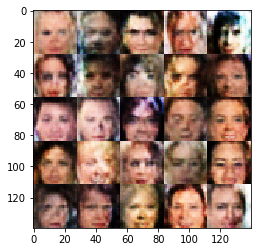

Epoch 1/1... Discriminator Loss: 1.3167... Generator Loss: 0.7319
Epoch 1/1... Discriminator Loss: 0.9563... Generator Loss: 1.8990
Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 1.2080
Epoch 1/1... Discriminator Loss: 1.1912... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.0847... Generator Loss: 1.2349
Epoch 1/1... Discriminator Loss: 1.0536... Generator Loss: 1.5330
Epoch 1/1... Discriminator Loss: 0.9928... Generator Loss: 1.3408
Epoch 1/1... Discriminator Loss: 1.0419... Generator Loss: 1.3042
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.7309


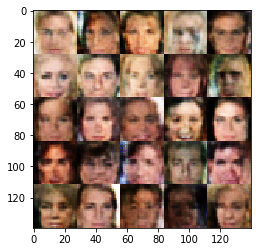

Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.6433
Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.6610
Epoch 1/1... Discriminator Loss: 0.9415... Generator Loss: 1.3972
Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 0.8401
Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 1.0573... Generator Loss: 0.9528
Epoch 1/1... Discriminator Loss: 1.0052... Generator Loss: 1.5592
Epoch 1/1... Discriminator Loss: 1.2611... Generator Loss: 0.8642
Epoch 1/1... Discriminator Loss: 1.2090... Generator Loss: 1.1294
Epoch 1/1... Discriminator Loss: 1.1082... Generator Loss: 1.5690


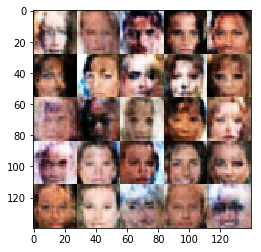

Epoch 1/1... Discriminator Loss: 1.1563... Generator Loss: 0.8946
Epoch 1/1... Discriminator Loss: 0.8129... Generator Loss: 1.9704
Epoch 1/1... Discriminator Loss: 1.3508... Generator Loss: 0.5934
Epoch 1/1... Discriminator Loss: 1.1722... Generator Loss: 0.9291
Epoch 1/1... Discriminator Loss: 1.1347... Generator Loss: 1.1808
Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.5630
Epoch 1/1... Discriminator Loss: 1.1594... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.2639... Generator Loss: 0.9090
Epoch 1/1... Discriminator Loss: 1.1886... Generator Loss: 0.8181
Epoch 1/1... Discriminator Loss: 1.0885... Generator Loss: 1.1254


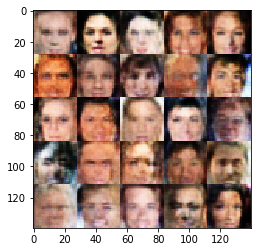

Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 1.4628
Epoch 1/1... Discriminator Loss: 1.2445... Generator Loss: 0.8012
Epoch 1/1... Discriminator Loss: 1.0493... Generator Loss: 1.2593
Epoch 1/1... Discriminator Loss: 1.0199... Generator Loss: 1.7213
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.5594
Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 0.5605
Epoch 1/1... Discriminator Loss: 0.9906... Generator Loss: 1.5513
Epoch 1/1... Discriminator Loss: 0.9792... Generator Loss: 1.3445
Epoch 1/1... Discriminator Loss: 1.2254... Generator Loss: 1.6041
Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 0.9425


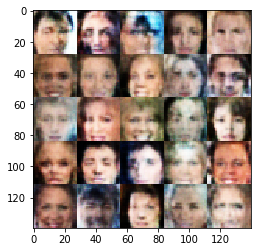

Epoch 1/1... Discriminator Loss: 1.0267... Generator Loss: 1.1337
Epoch 1/1... Discriminator Loss: 0.9160... Generator Loss: 1.2384
Epoch 1/1... Discriminator Loss: 1.0951... Generator Loss: 0.8782
Epoch 1/1... Discriminator Loss: 1.2834... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 1.2317... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.5970... Generator Loss: 0.4586
Epoch 1/1... Discriminator Loss: 1.0566... Generator Loss: 1.0811
Epoch 1/1... Discriminator Loss: 1.0077... Generator Loss: 1.1810
Epoch 1/1... Discriminator Loss: 1.2861... Generator Loss: 0.7323
Epoch 1/1... Discriminator Loss: 1.0307... Generator Loss: 1.2230


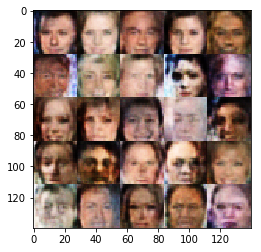

Epoch 1/1... Discriminator Loss: 0.9498... Generator Loss: 1.8240
Epoch 1/1... Discriminator Loss: 1.1228... Generator Loss: 1.6534
Epoch 1/1... Discriminator Loss: 1.4734... Generator Loss: 0.4961
Epoch 1/1... Discriminator Loss: 1.0867... Generator Loss: 0.9438
Epoch 1/1... Discriminator Loss: 1.1505... Generator Loss: 0.8900
Epoch 1/1... Discriminator Loss: 1.0221... Generator Loss: 1.0836
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 0.8358
Epoch 1/1... Discriminator Loss: 1.1276... Generator Loss: 1.1502
Epoch 1/1... Discriminator Loss: 0.9721... Generator Loss: 1.1485
Epoch 1/1... Discriminator Loss: 1.2058... Generator Loss: 0.8058


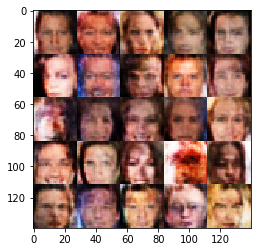

Epoch 1/1... Discriminator Loss: 1.1026... Generator Loss: 0.9877
Epoch 1/1... Discriminator Loss: 1.3057... Generator Loss: 0.6694
Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 0.8326
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.7272
Epoch 1/1... Discriminator Loss: 1.1187... Generator Loss: 1.0747
Epoch 1/1... Discriminator Loss: 0.9731... Generator Loss: 1.2848
Epoch 1/1... Discriminator Loss: 1.1330... Generator Loss: 1.4061
Epoch 1/1... Discriminator Loss: 1.0545... Generator Loss: 1.0460
Epoch 1/1... Discriminator Loss: 1.5040... Generator Loss: 0.4797


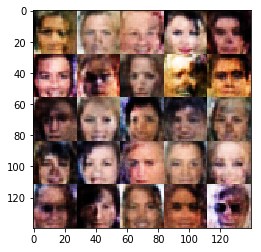

Epoch 1/1... Discriminator Loss: 1.1780... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.1266... Generator Loss: 0.9909
Epoch 1/1... Discriminator Loss: 1.2464... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 1.0391
Epoch 1/1... Discriminator Loss: 1.0464... Generator Loss: 1.1344
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.5461
Epoch 1/1... Discriminator Loss: 0.9630... Generator Loss: 1.3038
Epoch 1/1... Discriminator Loss: 1.6411... Generator Loss: 0.3698
Epoch 1/1... Discriminator Loss: 1.0953... Generator Loss: 0.9598
Epoch 1/1... Discriminator Loss: 1.0118... Generator Loss: 1.2599


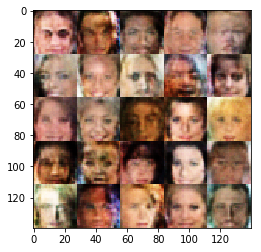

Epoch 1/1... Discriminator Loss: 1.0569... Generator Loss: 1.0332
Epoch 1/1... Discriminator Loss: 1.0707... Generator Loss: 1.3884
Epoch 1/1... Discriminator Loss: 1.0366... Generator Loss: 0.9353
Epoch 1/1... Discriminator Loss: 1.1362... Generator Loss: 1.2520
Epoch 1/1... Discriminator Loss: 1.1887... Generator Loss: 0.6684
Epoch 1/1... Discriminator Loss: 1.0023... Generator Loss: 0.9998
Epoch 1/1... Discriminator Loss: 1.2912... Generator Loss: 1.3134
Epoch 1/1... Discriminator Loss: 0.8598... Generator Loss: 1.2430
Epoch 1/1... Discriminator Loss: 0.9147... Generator Loss: 1.8349
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.5380


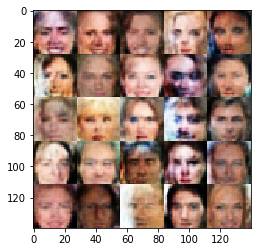

Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 0.7190
Epoch 1/1... Discriminator Loss: 0.9729... Generator Loss: 1.4666
Epoch 1/1... Discriminator Loss: 1.3162... Generator Loss: 0.6288
Epoch 1/1... Discriminator Loss: 1.1029... Generator Loss: 1.1329
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.5438
Epoch 1/1... Discriminator Loss: 1.1485... Generator Loss: 1.0845
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 1.2280
Epoch 1/1... Discriminator Loss: 1.1011... Generator Loss: 0.9821
Epoch 1/1... Discriminator Loss: 1.2016... Generator Loss: 0.9703
Epoch 1/1... Discriminator Loss: 1.1926... Generator Loss: 1.5235


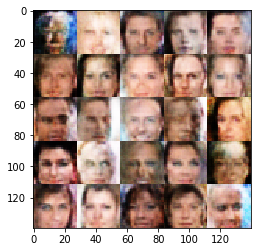

Epoch 1/1... Discriminator Loss: 1.0092... Generator Loss: 0.8754
Epoch 1/1... Discriminator Loss: 1.0041... Generator Loss: 1.6763
Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.6635
Epoch 1/1... Discriminator Loss: 1.1854... Generator Loss: 0.8334
Epoch 1/1... Discriminator Loss: 1.0814... Generator Loss: 1.0504
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.6497
Epoch 1/1... Discriminator Loss: 1.1619... Generator Loss: 1.0423
Epoch 1/1... Discriminator Loss: 1.2305... Generator Loss: 0.8140


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = .0001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.